In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from six import StringIO
import json
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
from sklearn import metrics
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split

# visualization
%matplotlib inline
import seaborn as sns

In [ ]:
#Importing data into dataframes
files = ['yelp_academic_dataset_business.json', 'yelp_academic_dataset_checkin.json', 'yelp_academic_dataset_user.json', 
         'yelp_academic_dataset_review.json', 'yelp_academic_dataset_tip.json', 'yelp_academic_dataset_covid_features.json']

business = [json.loads(line) for line in open(files[0], 'r',encoding="utf8")]
business = pd.DataFrame.from_dict(business)

checkin = [json.loads(line) for line in open(files[1], 'r',encoding="utf8")]
checkin = pd.DataFrame.from_dict(checkin)

user = [json.loads(line) for line in open(files[2], 'r',encoding="utf8")]
user = pd.DataFrame.from_dict(user)

review = [json.loads(line) for line in open(files[3], 'r',encoding="utf8")]
review = pd.DataFrame.from_dict(review)

tip = [json.loads(line) for line in open(files[4], 'r',encoding="utf8")]
tip = pd.DataFrame.from_dict(tip)

covid = [json.loads(line) for line in open(files[5], 'r',encoding="utf8")]
covid = pd.DataFrame.from_dict(covid)

In [2]:
#convert date to datetime
from datetime import datetime
checkin.date = checkin.date.apply(lambda x: x.split(", "))

def convert_todate(row):
    converted = pd.to_datetime(row,format = '%Y-%m-%d %H:%M:%S' )
    return converted
    
checkin['datetime'] = checkin.date.apply(convert_todate)

In [3]:
#get latest checkin date
checkin['latest_checkin'] = checkin.date.apply(lambda x: max(x))
checkin.latest_checkin = pd.to_datetime(checkin.latest_checkin,format = '%Y-%m-%d %H:%M:%S' )
checkin['last_checkin_year'] = checkin.latest_checkin.apply(lambda x: x.year)

In [4]:
#merge dfs
business_checkin = pd.merge(business, checkin, on="business_id", how='left')

In [5]:
#change columns format
new_columns = []
for column in covid.columns:
    new = column.replace(" ", "_")
    new_columns.append(new)

covid.columns = new_columns

In [7]:
#see how many businesses have temporarily closed
openPreCovid = compiled[compiled['is_open'] == 1]
covid_closure = openPreCovid[openPreCovid['Temporary_Closed_Until']!= 'FALSE']
covid_closure.shape[0]

1378

In [8]:
#only keep rows where covid info is displayed
covid= covid[['business_id','Call_To_Action_enabled', 'Covid_Banner', 'Grubhub_enabled', 'Request_a_Quote_Enabled', 'Temporary_Closed_Until',
       'Virtual_Services_Offered',  'delivery_or_takeout',
       'highlights']]

covid['covid_info'] = covid.iloc[:, 1:].nunique(axis = 1).eq(1)
covid_info = covid[covid['covid_info'] == False]
covid_info = covid_info.drop_duplicates()

#add covid df
compiled = pd.merge(business_checkin, covid_info, on='business_id', how='right')
compiled

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,...,last_checkin_year,Call_To_Action_enabled,Covid_Banner,Grubhub_enabled,Request_a_Quote_Enabled,Temporary_Closed_Until,Virtual_Services_Offered,delivery_or_takeout,highlights,covid_info
0,4827 E Downing Cir,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...",51M2Kk903DFYI6gnB5I6SQ,"Home Services, Plumbing, Electricians, Handyma...",Mesa,"{'Monday': '0:0-0:0', 'Tuesday': '9:0-16:0', '...",1,33.428065,-111.726648,USE MY GUY SERVICES LLC,...,2017.0,TRUE,The team at Use My Guy Services are taking saf...,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,False
1,6910 E Southern Ave,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...",ScYkbYNkDgCneBrD9vqhCQ,"Auto Repair, Oil Change Stations, Automotive, ...",Mesa,"{'Monday': '7:30-17:0', 'Tuesday': '7:30-17:0'...",1,33.393885,-111.682226,Junction Tire & Auto Service,...,2019.0,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,False
2,404 E Green St,"{'RestaurantsAttire': 'u'casual'', 'Restaurant...",pQeaRpvuhoEqudo3uymHIQ,"Ethnic Food, Food Trucks, Specialty Food, Impo...",Champaign,"{'Monday': '11:30-14:30', 'Tuesday': '11:30-14...",1,40.110446,-88.233073,The Empanadas House,...,2017.0,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,False
3,2831 Parmenter St,"{'BikeParking': 'True', 'Caters': 'True', 'Whe...",M_guz7Dj7hX0evS672wIwA,"Desserts, Food, Ice Cream & Frozen Yogurt",Middleton,"{'Monday': '0:0-0:0', 'Tuesday': '11:0-21:0', ...",1,43.105310,-89.510142,Chocolate Shoppe Ice Cream,...,2019.0,FALSE,Covid-19 update: We are open for business 12pm...,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,False
4,2402 Atchley Dr,{'BusinessAcceptsCreditCards': 'True'},rqcOZePlVvJP9EtzldIz0w,"Local Services, Self Storage",Henderson,"{'Monday': '8:0-18:0', 'Tuesday': '8:0-18:0', ...",0,35.952046,-115.093483,Desert Storage,...,2017.0,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,False
5,"2115 E Cedar St, Unit 3","{'BusinessAcceptsCreditCards': 'True', 'Restau...",nIEhsGbw0vJuYl05bzzj6Q,"Event Planning & Services, Wedding Planning, F...",Tempe,None,1,33.411514,-111.895378,Bloom & Blueprint,...,NaN,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,False
6,5229 S Power Rd,"{'AcceptsInsurance': 'False', 'GoodForKids': '...",Vwo64kNYDjKi98gUUv4-iQ,"Weight Loss Centers, Fitness & Instruction, Bo...",Mesa,"{'Monday': '5:30-20:0', 'Tuesday': '5:30-20:0'...",1,33.320723,-111.685869,Gateway Fit Body Boot Camp,...,2019.0,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,False
7,4508 E Independence Blvd,"{'RestaurantsGoodForGroups': 'True', 'OutdoorS...",CsLQLiRoafpJPJSkNX2h5Q,"Food, Restaurants, Grocery, Middle Eastern",Charlotte,None,0,35.194894,-80.767442,Middle East Deli,...,2013.0,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,False
8,"15480 Bayview Avenue, unit D0110","{'RestaurantsTableService': 'False', 'Restaura...",eBEfgOPG7pvFhb2wcG9I7w,"Restaurants, Cheesesteaks, Poutineries",Aurora,"{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",1,44.010962,-79.448677,Philthy Phillys,...,2019.0,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,False
9,300 John Street,"{'GoodForKids': 'True', 'RestaurantsTakeOut': ...",lu7vtrp_bE9PnxWfA8g4Pg,"Japanese, Fast Food, Food Court, Restaurants",Thornhill,None,1,43.820492,-79.398466,Banzai Sushi,...,2018.0,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,False


In [9]:
#Change closed values to 0 or 1
compiled.Temporary_Closed_Until[compiled.Temporary_Closed_Until == 'FALSE'] = 0
compiled.Temporary_Closed_Until[compiled.Temporary_Closed_Until != 0] = 1

C:\Users\salma.katri\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\salma.katri\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
#calculate number of reviews per business, average rating and std 
reviews_summary = review.groupby('business_id').stars.agg([np.size, np.mean, np.std]).reset_index()

#get latest review date 
review['datetime'] = review.date.apply(convert_todate)
latest_review = review.groupby('business_id').datetime.max().reset_index()

In [11]:
#merge to main dataframe
reviews_summary = pd.merge(reviews_summary, latest_review, on='business_id', how='left')
reviews_summary.columns = ['business_id', 'nb_reviews', 'avg_rating', 'std_rating', 'latest_review']

In [12]:
final_data = pd.merge(compiled, reviews_summary, on='business_id', how = 'left')

In [13]:
#keep columns to use for analysis
df = final_data[['business_id','name','address', 'city', 'state','attributes',  'categories',  'hours', 'review_count', 
                 'stars', 'datetime', 'latest_checkin','last_checkin_year', 'Call_To_Action_enabled', 'Covid_Banner',
                 'Grubhub_enabled','Request_a_Quote_Enabled', 'Temporary_Closed_Until','Virtual_Services_Offered',
                 'delivery_or_takeout', 'highlights','covid_info', 'nb_reviews', 'avg_rating', 'std_rating','latest_review']]

df.columns = ['business_id','name','address', 'city', 'state','attributes',  'categories',  'hours', 'review_count', 
                 'stars', 'checkin_dates', 'latest_checkin','last_checkin_year', 'Call_To_Action_enabled', 'Covid_Banner',
                 'Grubhub_enabled','Request_a_Quote_Enabled', 'covid_closed','Virtual_Services_Offered',
                 'delivery_or_takeout', 'highlights','covid_info', 'nb_reviews', 'avg_rating', 'std_rating','latest_review']

In [14]:
#get food categories 
categoriesDF = df.categories.str.get_dummies(sep = ",")
obs_per_cat = categoriesDF.sum().reset_index()
obs_per_cat.columns = ['category', 'sum']

FoodCategoriesDF = categoriesDF[['Restaurants', ' Restaurants', 'Food', ' Food', 'Fast Food', ' Fast Food']]
FoodCategoriesDF.columns = ['Restaurant1', 'Restaurant2', 'Food1', 'Food2', 'Fast_Food1', 'Fast_Food2']

def get_food_business(row):
    if ((row['Restaurant1'] ==1 )or (row['Restaurant2'] ==1) or (row['Food1'] == 1) or (row['Food2'] == 1) 
        or (row['Fast_Food1']==1) or (row['Fast_Food2'] ==1)):
        return 1
    else:
        return 0
    
def get_fast_food(row):
    if (row['Fast_Food1']==1) or (row['Fast_Food2'] ==1):
        return 1
    else:
        return 0 
    
FoodCategoriesDF['food_business'] = FoodCategoriesDF.apply(get_food_business, axis=1)    
FoodCategoriesDF['fast_food'] = FoodCategoriesDF.apply(get_fast_food, axis=1)             

C:\Users\salma.katri\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\salma.katri\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [15]:
#get df of food businesses
df = pd.concat([df, FoodCategoriesDF], axis = 1)
Food = df[df.food_business ==1]

In [16]:
#consider getting into type of cuisine

In [17]:
#keep columns we need
FoodDF = Food[['business_id', 'name', 'address', 'city', 'state', 'attributes','review_count', 'stars', 'checkin_dates',
               'latest_checkin', 'last_checkin_year', 'Call_To_Action_enabled','Covid_Banner', 'Grubhub_enabled', 
               'covid_closed', 'delivery_or_takeout','highlights','covid_info', 'nb_reviews', 'avg_rating', 'std_rating',
               'latest_review','food_business', 'fast_food']]

In [18]:
#add number of restaurant locations
locations = pd.DataFrame(FoodDF.name.value_counts()).reset_index()
locations.columns = ['name', "nb_locations"]

FoodDF = pd.merge(FoodDF, locations, on='name', how='left')

In [25]:
#convert to dummies (city, state)
cities = pd.get_dummies(FoodDF.city).astype(int)
FoodDF = pd.concat([FoodDF, cities], axis=1)

states = pd.get_dummies(FoodDF.state).astype(int)
FoodDF = pd.concat([FoodDF, states], axis=1)

In [31]:
#add country
canada = ['ON', 'QC', 'AB', 'XWY', 'BC', 'MB'] 
def get_country(row):
    if row['state'] in canada:
        return 0
    else:
        return 1
    
FoodDF['country'] = FoodDF.apply(get_country, axis=1)    

In [56]:
#get number of checkin_dates
def get_checkins(row):
    if isinstance(row['checkin_dates'], float):
        return 0
    else:
        return len(row['checkin_dates'])
FoodDF['nb_checkins'] = FoodDF.apply(get_checkins, axis = 1)

In [67]:
#convert to binary (call to action, covid banner, grubhub, delivery, covid_info, highlights)
FoodDF['call_to_action'] = FoodDF['Call_To_Action_enabled'].apply(lambda x: 0 if x == 'FALSE' else 1)
FoodDF['covid_banner'] = FoodDF['Covid_Banner'].apply(lambda x: 0 if x == 'FALSE' else 1)
FoodDF['grubhub'] = FoodDF['Grubhub_enabled'].apply(lambda x: 0 if x == 'FALSE' else 1)
FoodDF['delivery_takout'] = FoodDF['delivery_or_takeout'].apply(lambda x: 0 if x == 'FALSE' else 1)
FoodDF['additional_info'] = FoodDF['highlights'].apply(lambda x: 0 if x == 'FALSE' else 1)

In [90]:
#get price range
def get_price_range(row):
    if isinstance(row, dict):
        if 'RestaurantsPriceRange2' in row:
            return row['RestaurantsPriceRange2']
        else:
            return 'NA'
    else:
        return 'NA'
    
FoodDF['price_range'] = FoodDF.attributes.apply(get_price_range)

FoodDF.loc[FoodDF['price_range'] == 'None', ['price_range']] = 'NA'

In [146]:
#remove name, address and business_id, covid_info, last_checkin_year
df = FoodDF[['covid_closed','review_count','stars','latest_checkin','nb_reviews',
 'avg_rating',
 'std_rating',
 'latest_review',
 'fast_food',
 'nb_locations',
 '4321 W Flamingo Rd',
 'Agincourt',
 'Ahwatukee',
 'Airdrie',
 'Ajax',
 'Akron',
 'Alberta',
 'Allentown',
 'Allison Park',
 'Ambridge',
 'Amherst',
 'Anjou',
 'Anthem',
 'Apache Junction',
 'Arnold',
 'Ashburn',
 'Aspinwall',
 'Aurora',
 'Austinburg',
 'Avalon',
 'Avon',
 'Avon Lake',
 'Avon lake',
 'Avondale',
 "Baie-d'Urfé",
 'Bainbridge',
 'Bainbridge Township',
 'Baldwin',
 'Balzac',
 'Bath',
 'Bay Village',
 'Beachwood',
 'Beaconsfield',
 'Beauharnois',
 'Bedford',
 'Bedford Heights',
 'Bedford Hts.',
 'Beeton',
 'Belle Vernon',
 'Belleville',
 'Bellevue',
 'Bellvue',
 'Belmont',
 'Beloeil',
 'Belœil',
 'Ben Avon',
 'Berea',
 'Bethel Park',
 'Black Earth',
 'Blainville',
 'Blakeney',
 'Blawnox',
 'Blue Diamond',
 'Bois-des-Filion',
 'Boisbriand',
 'Bolton',
 'Bond Head',
 'Boucherville',
 'Boulder City',
 'Braddock',
 'Bradford',
 'Bradford West Gwillimbury',
 'Brampton',
 'Bratenahl',
 'Brecksville',
 'Brentwood',
 'Bridgeville',
 'Broadview Heights',
 'Brook Park',
 'Brooklin',
 'Brookline',
 'Brooklyn',
 'Brookpark',
 'Brossard',
 'Brunswick',
 'Brunswick Hills',
 'Buckeye',
 'Buena Vista',
 'Burton',
 'CLEVELAND',
 'Caledon',
 'Caledon East',
 'Caledon Village',
 'Calgary',
 'Candiac',
 'Canonsburg',
 'Carefree',
 'Carnegie',
 'Castle Shannon',
 'Catawba Springs',
 'Cave Creek',
 'Cecil',
 'Centennial',
 'Central',
 'Central City',
 'Central City Village',
 'Centre Island',
 'Chagrin Falls',
 'Chambly',
 'Champaign',
 'Champlain',
 'Chandler',
 'Chardon',
 'Chargrin Falls',
 'Charlotte',
 'Chatauguay',
 'Chateauguay',
 'Chertsey',
 'Chesterland',
 'Chestermere',
 'Cheswick',
 'Chicago',
 'Châteauguay',
 'Clairton',
 'Clarkson',
 'Cleveland',
 'Cleveland Heights',
 'Cleveland Hts.',
 'Clover',
 'Columbia Station',
 'Columbus',
 'Communauté-Urbaine-de-Montréal',
 'Concord',
 'Concord Mills',
 'Concord Township',
 'Concord Twp',
 'Copley',
 'Coraopolis',
 'Cornelius',
 'Cote Saint-Luc',
 'Cote-Saint-Luc',
 'Coteau-du-Lac',
 'Cottage Grove',
 'Crafton',
 'Cramerton',
 'Creighton',
 'Crescent',
 'Cross Plains',
 'Cuddy',
 'Cuyahoga Falls',
 'Cuyahoga Fls',
 'Cuyahoga Heights',
 'Côte Saint-Luc',
 'Côte-Saint-Luc',
 'Dallas',
 'Dane',
 'Davidson',
 'De Forest',
 "De l'Eglise",
 'DeForest',
 'Deforest',
 'Delson',
 'Denver',
 'Deux-Montagnes Regional County Municipality',
 'Division No. 6',
 'Dollard-Des Ormeaux',
 'Dollard-Des-Ormeaux',
 'Dollard-des Ormeaux',
 'Dollard-des-Ormeaux',
 'Don Mills',
 'Dormont',
 'Dorval',
 'Downsview',
 'Downtown Toronto',
 'Dravosburg',
 'Duquesne',
 'Duvernay',
 'ETOBICOKE',
 'East Calgary',
 'East Cleveland',
 'East Gwillimburry',
 'East Gwillimbury',
 'East Liberty',
 'East Mc Keesport',
 'East McKeesport',
 'East Mississauga',
 'East Pittsburgh',
 'East York',
 'Eastlake',
 'Edgewood',
 'El Mirage',
 'Elizabeth',
 'Elizabeth Township',
 'Elrama',
 'Elyria',
 'Emsworth',
 'Enterprise',
 'Erie',
 'Etibicoke',
 'Etna',
 'Etobicoke',
 'Etobiicoke',
 'Euclid',
 'Export',
 'Fabreville',
 'Fairlawn',
 'Fairport Harbor',
 'Fairview Park',
 'Farnham',
 'Finleyville',
 'Fisher',
 'Fitchburg',
 'Fithian',
 'Forest Hills',
 'Fort  Mill',
 'Fort McDowell',
 'Fort Mcdowell',
 'Fort Mill',
 'Fort Mills',
 'Fountain Hills',
 'Fox Chapel',
 'Franklin Park',
 'Ft. Mill',
 'Ft.Mill',
 'GILBERT',
 'Garfield Heights',
 'Garfield Hts',
 'Garfield Hts.',
 'Gastonia',
 'Gates Mills',
 'Geauga',
 'Gelndale',
 'Georgetown',
 'Gibsonia',
 'Gifford',
 'Gilbert',
 'Glassport',
 'Glendale',
 'Glendale Az',
 'Glenshaw',
 'Goodwood',
 'Goodyear',
 'Gormley',
 'Grafton',
 'Grand River',
 'Green Tree',
 'Greenfield Park',
 'Greenfield-Park',
 'Guadalupe',
 'Halton Hills',
 'Hampstead',
 'Hampton Township',
 'Harmarville',
 'Harrisburg',
 'Harrison City',
 'Harwick',
 'Heidelberg',
 'Henderson',
 'Hendersonville',
 'Henryville',
 'Herminie',
 'Highland Heights',
 'Higley',
 'Hinckley',
 'Hiram',
 'Holland Landing',
 'Homer',
 'Homestead',
 'Hopewell',
 'Hudson',
 'Huntersville',
 'Huntingdon',
 'Iberville',
 'Imperial',
 'Independence',
 'Indian Land',
 'Indian Land,',
 'Indian Trail',
 'Indian land',
 'Indianola',
 'Inglewood',
 'Ingomar',
 'Irwin',
 'Jefferson Hills',
 'Joliette',
 'Kahnawake',
 'Kannapolis',
 'Kennedy Township',
 'Kent',
 'King',
 'King City',
 'Kirkland',
 'Kirtland',
 'Kleinburg',
 "L'Assomption",
 "L'ile-Bizard",
 "L'ile-Perrot",
 "L'Île-Bizard",
 "L'Île-Perrot",
 "L'Île-des-Sœurs",
 'LAS VEGAS',
 'La Prairie',
 'La Salle',
 'LaGrange',
 'LaSalle',
 'Lachenaie',
 'Lachine',
 'Lachute',
 'Lagrange',
 'Lake Park',
 'Lake Wylie',
 'Lakewood',
 'Las  Vegas',
 'Las Vegas',
 'Las vegas',
 'Lasalle',
 'Laval',
 'Laveen',
 'Laveen Village',
 'Lawrence',
 'Lawrenceville',
 'Leeds',
 'Leetsdale',
 'Lemon Grove',
 'Library',
 'Litchfield',
 'Litchfield Park',
 'Locust',
 'Longueuil',
 'Lorain',
 'Lowell',
 'Lower Burrell',
 'Lower Lawrenceville',
 'Lower burrell',
 'Lowesville',
 'Lyndhurst',
 'MESA',
 'Macedonia',
 'Madison',
 'Mahomet',
 'Malton',
 'Mansfield',
 'Mantua',
 'Maple',
 'Maple Grove',
 'Maple Heights',
 'Maple Hts.',
 'Maricopa',
 'Marieville',
 'Markham',
 'Mascouche',
 'Mattews',
 'Matthews',
 'Mayfield',
 'Mayfield Heights',
 'Mayfield Hgts',
 'Mayfield Hts',
 'Mayfield Hts.',
 'Mayfield Village',
 'Mc Donald',
 'Mc Farland',
 'Mc Kees Rocks',
 'Mc Murray',
 'McAdenville',
 'McCandless Township',
 'McDonald',
 'McFarland',
 'McKees Rocks',
 'McKeesport',
 'McKnight',
 'McMasterville',
 'McMurray',
 'Mcdonald',
 'Mcfarland',
 'Mckees Rocks',
 'Mckeesport',
 'Mcknight',
 'Mcmurray',
 'Medina',
 'Medina Township',
 'Mentor',
 'Mentor On The Lake',
 'Mentor On the',
 'Mentor On the Lake',
 'Mentor ohio',
 'Mentor-On-The-Lake',
 'Mentor-on-the-Lake',
 'Mercier',
 'Mes',
 'Mesa',
 'Metro Phoenix',
 'Middleburg Heights',
 'Middleburg Hts.',
 'Middlefield',
 'Middleton',
 'Midland',
 'Midnapore',
 'Midway',
 'Millvale',
 'Milton',
 'Mint  Hill',
 'Mint Hill',
 'Mirabel',
 'Missisauga',
 'Mississauga',
 'Mississuaga',
 'Monona',
 'Monongahela',
 'Monroe',
 'Monroeville',
 'Mont-Royal',
 'Mont-Saint-Hilaire',
 'Monterey Park',
 'Monticello',
 'Montreal',
 'Montreal-Est',
 'Montreal-Nord',
 'Montreal-Ouest',
 'Montreal-West',
 'Montrose',
 'Montrèal',
 'Montréal',
 'Montréal-Nord',
 'Montréal-Ouest',
 'Montréal-West',
 'Moon',
 'Moon TWP',
 'Moon Township',
 'Moon Twp',
 'Mooresville',
 'Moreland Hills',
 'Morin-Heights',
 'Mount Albert',
 'Mount Holly',
 'Mount Horeb',
 'Mount Lebanon',
 'Mount Royal',
 'Mount Washington',
 'Mt Holly',
 'Mt Lebanon',
 'Mt. Holly',
 'Mt. Lebanon',
 'Munhall',
 'Munroe Falls',
 'Murrysville',
 'N Las Vegas',
 'N Ridgeville',
 'N Versailles',
 'N. Las Vegas',
 'N.Las Vegas',
 'N.Olmsted',
 'N.Ridgeville',
 'N.Versailles',
 'Napierville',
 'Nellis AFB',
 'Nellis Afb',
 'Nellis Air Force Base',
 'Neville Island',
 'New Eagle',
 'New Kensington',
 'New Tecumseth',
 'Newbury',
 'Newbury Township',
 'Newmarket',
 'Nobleton',
 'North  York',
 'North Charlotte',
 'North Huntingdon',
 'North Huntington',
 'North Las Vegas',
 'North Olmstead',
 'North Olmsted',
 'North Olmsted,',
 'North Randall',
 'North Ridgeville',
 'North Royalton',
 'North Strabane Township',
 'North Toronto',
 'North Versailles',
 'North York',
 'Northfield',
 'Northwest Calgary',
 'Northyork',
 'Norton',
 'Oak Ridges',
 'Oakdale',
 'Oakland',
 'Oakmont',
 'Oakvile',
 'Oakville',
 'Oakwood',
 'Oakwood Village',
 'Ogden',
 'Oka',
 'Olmsted Falls',
 'Olmsted Township',
 'Olmsted Twp',
 'Orange',
 'Orange Village',
 'Oregon',
 'Ormstown',
 'Oshawa',
 'Otterburn Park',
 'Outremont',
 'PHOENIX',
 'PIttsburgh',
 'Pahrump',
 'Painesville',
 'Painesville Township',
 'Paoli',
 'Paradise',
 'Paradise Valley',
 'Parma',
 'Parma Heights',
 'Parma Hts.',
 'Paw Creek',
 'Peninsula',
 'Penn Hills',
 'Peoria',
 'Pepper Pike',
 'Perry',
 'Peters (Township Of)',
 'Peters Township',
 'Pheonix',
 'Pheonix AZ',
 'Philo',
 'Phoenix',
 'Phx',
 'Pickering',
 'Piedmont',
 'Pierrefonds',
 'Pincourt',
 'Pineville',
 'Pitcairn',
 'Pittsburg',
 'Pittsburgh',
 'Pleasant Hills',
 'Plum',
 'Plum Boro',
 'Pointe-Aux-Trembles',
 'Pointe-Claire',
 'Pointe-aux-Trembles',
 'Pont-Viau',
 'Port Credit',
 'Port Vue',
 'Presto',
 'Prévost',
 'Quartier des Spectacles',
 'Queen Creek',
 'Queen creek',
 'Québec',
 'Rankin',
 'Ranlo',
 'Rantoul',
 'Ravenna',
 'Rawdon',
 'Regional Municipality of York',
 'Repentigny',
 'Rexdale',
 'Richfield',
 'Richmond Height',
 'Richmond Heights',
 'Richmond Hil',
 'Richmond Hill',
 'Richmond Hts',
 'Richmond Hts.',
 'Rigaud',
 'Rillton',
 'Rio Verde',
 'River Drive Park',
 'Robinson',
 'Robinson Township',
 'Robinson Twp.',
 'Rock Hill',
 'Rocky River',
 'Rocky View',
 'Rocky View County',
 'Rocky View No. 44',
 'Rosemere',
 'Rosemère',
 'Ross Township',
 'Rostraver',
 'Rougemont',
 'Rouses Point',
 'Roxboro',
 'Rural Ridge',
 'Russellton',
 'RŽpentigny',
 'S.Euclid',
 'Sagamore Hills',
 'Saint Joseph',
 'Saint Laurent',
 'Saint Leonard',
 'Saint-Basile-le-Grand',
 'Saint-Bruno',
 'Saint-Bruno-de-Montarville',
 'Saint-Charles-Borromée',
 'Saint-Constant',
 'Saint-Eustache',
 'Saint-Henri',
 'Saint-Hippolyte',
 'Saint-Hubert',
 'Saint-Hyacinthe',
 'Saint-Jean-Sur-Richelieu',
 'Saint-Jean-sur-Richelieu',
 'Saint-Jerome',
 'Saint-Jérôme',
 'Saint-Lambert',
 'Saint-Laurent',
 'Saint-Lazare',
 'Saint-Leonard',
 'Saint-Liboire',
 'Saint-Léonard',
 'Saint-Sauveur',
 'Saint-Sauveur-Des-Monts',
 'Saint-Sauveur-des-Monts',
 'Saint-laurent',
 'Sainte- Adele',
 'Sainte-Adele',
 'Sainte-Adèle',
 'Sainte-Anne-De-Bellevue',
 'Sainte-Anne-de-Bellevue',
 'Sainte-Catherine',
 'Sainte-Genevieve',
 'Sainte-Julie',
 'Sainte-Madeleine',
 'Sainte-Marguerite-du-Lac-Masson',
 'Sainte-Marguerite-du-lac-Masson',
 'Sainte-Marthe',
 'Sainte-Therese',
 'Sainte-Thérèse',
 'Sainte-Thérèse-de-Blainville',
 'Sainte-thérèse',
 'Saintt-Bruno-de-Montarville',
 'Salaberry-De-Valleyfield',
 'Salem',
 'San Antonio',
 'Sauk City',
 'Savoy',
 'Scarborough',
 'Scarobrough',
 'Schomberg',
 'Schottsdale',
 'Scottdale',
 'Scottsdale',
 'Sedona',
 'Seven Hills',
 'Sewickley',
 'Shaker Heights',
 'Shaler Township',
 'Sharpsburg',
 'Sheboygan',
 'Sheffield',
 'Sheffield Lake',
 'Sheffield Village',
 'Sidney',
 'Solon',
 'South Amherst',
 'South Euclid',
 'South Las Vegas',
 'South Park',
 'South Park Township',
 'Southeast Calgary',
 'Spring Hill City View',
 'Spring Valley',
 'Springdale',
 'Squirrel Hill',
 'St Joseph',
 'St Leonard',
 'St-Bruno-de-Montarville',
 'St-Clet',
 'St-Jean Sur Richelieu',
 'St-Jean-sur-Richelieu',
 'St-Jerome',
 'St-Laurent',
 'St-Leonard',
 'St-Sauveur',
 'St. Joseph',
 'St. Léonard',
 'Stallings',
 'Stanley',
 'Ste-Dorothée',
 'Ste-Rose',
 'Stouffville',
 'Stoughton',
 'Stow',
 'Streetsboro',
 'Streetsville',
 'Strongsville',
 'Sturgeon',
 'Summerlin',
 'Summerlin South',
 'Sun City',
 'Sun City West',
 'Sun Lakes',
 'Sun Prairie',
 'Sunrise Manor',
 'Surprise',
 'Sutersville',
 'Swissvale',
 'Tallmadge',
 'Tarentum',
 'Tega Cay',
 'Tempe',
 'Terrebonne',
 'Thorncliffe Park',
 'Thornhil',
 'Thornhill',
 'Tolleson',
 'Tolono',
 'Tornto',
 'Toronto',
 'Trafford',
 'Tremont',
 'Troy Township',
 'Turtle Creek',
 'Tuscola',
 'Twinsburg',
 'Unionville',
 'University Heights',
 'Upper Saint Clair',
 'Upper St Clair',
 'Urbana',
 'Uxbridge',
 'Valley City',
 'Valley View',
 'Valleyfield',
 'Vaudreuil',
 'Vaudreuil-Dorion',
 'Vaughan',
 'Venetia',
 'Venise-en-Québec',
 'Verdun',
 'Verona',
 'Verrado',
 'Villa Grove',
 'Ville Mont-Royal',
 'Vimont',
 'W Henderson',
 'W.Mifflin',
 'Waddell',
 'Wadsworth',
 'Wahiawa',
 'Walton Hills',
 'Warrensville',
 'Warrensville Heights',
 'Warrensville Hts.',
 'Waterloo',
 'Waunakee',
 'Waxhaw',
 'Weddington',
 'Wesley Chapel',
 'West Elizabeth',
 'West Homestead',
 'West Lake',
 'West Mifflin',
 'West View',
 'Westlake',
 'Westmount',
 'Westport',
 'Wexford',
 'Whiitby',
 'Whitaker',
 'Whitby',
 'Whitchurch-Stouffville',
 'White Oak',
 'Whtiby',
 'Wickliffe',
 'Wilkens Township',
 'Wilkins',
 'Wilkinsburg',
 'Willoughby',
 'Willoughby Hills',
 'Willowdale',
 'Willowick',
 'Wilmerding',
 'Windsor',
 'Woodbridge',
 'Woodbridge (Vaughan)',
 'Woodmere',
 'Woodmere Village',
 'York',
 'York Regional Municipality',
 'Youngtown',
 'cave creek',
 'charlotte',
 'kirtland',
 'laveen',
 'lyndhurst',
 'solon',
 'south Euclid',
 'Île-Perrot',
 'Île-des-Soeurs',
 'AB',
 'AR',
 'AZ',
 'BC',
 'CA',
 'CO',
 'FL',
 'HI',
 'IL',
 'MB',
 'NC',
 'NV',
 'NY',
 'OH',
 'ON',
 'OR',
 'PA',
 'QC',
 'SC',
 'TX',
 'VA',
 'WA',
 'WI',
 'XWY',
 'country',
 'nb_checkins',
 'call_to_action',
 'covid_banner',
 'grubhub',
 'delivery_takout',
 'additional_info',
 'price_range']]

In [147]:
#fill in missing values in price range
df.loc[df['price_range'] == 'NA', ['price_range']] = 1.5

C:\Users\salma.katri\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [148]:
#convert dates to numeric
df['latest_checkin'] = pd.to_numeric(pd.to_datetime(df['latest_checkin']))
df['latest_review'] = pd.to_numeric(pd.to_datetime(df['latest_review']))

C:\Users\salma.katri\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\salma.katri\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
#convert covid_closed to numeric
df['covid_closed'] = pd.to_numeric(df['covid_closed'])

In [212]:
#correlation matrix
df[df.columns].corr()['covid_closed'][:]

covid_closed          1.000000
review_count          0.138282
stars                 0.021428
latest_checkin        0.012883
nb_reviews            0.137577
avg_rating            0.022431
std_rating            0.001611
latest_review         0.053526
fast_food            -0.018664
nb_locations         -0.013123
4321 W Flamingo Rd   -0.000364
Agincourt            -0.000515
Ahwatukee            -0.000728
Airdrie               0.001611
Ajax                 -0.004711
Akron                -0.005221
Alberta              -0.000364
Allentown            -0.000364
Allison Park         -0.002154
Ambridge             -0.001587
Amherst              -0.002652
Anjou                -0.001151
Anthem               -0.001151
Apache Junction      -0.000814
Arnold               -0.000631
Ashburn              -0.000364
Aspinwall            -0.000963
Aurora               -0.002080
Austinburg           -0.000364
Avalon               -0.000892
                        ...   
AR                   -0.000364
AZ      

(array([58563.,  2594.,  2137.,     0.,     0.,   610.,     0.,   842.,
            0.,  1113.]),
 array([1.0000e+00, 1.1340e+02, 2.2580e+02, 3.3820e+02, 4.5060e+02,
        5.6300e+02, 6.7540e+02, 7.8780e+02, 9.0020e+02, 1.0126e+03,
        1.1250e+03]),
 <a list of 10 Patch objects>)

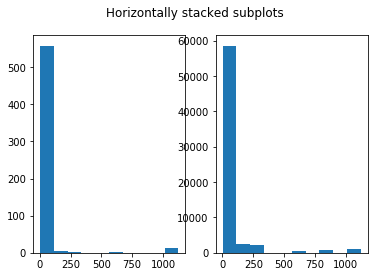

In [233]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Horizontally stacked subplots')
ax1.hist(df[df['covid_closed']==1]['nb_locations'])
ax2.hist(df[df['covid_closed']==0]['nb_locations'])

In [284]:
#balancing the data
df_closed = df[df['covid_closed']==1]
df_open = df[df['covid_closed']==0]
closed = df_closed.shape[0]
opened = df_open.shape[0]
add_rows = opened - closed

to_add = df_closed.sample(n=add_rows, replace=True)
df  = pd.concat([df, to_add], axis=0)

65279

In [291]:
#get train and test data
X = df.iloc[:, 1:]
y = df[['covid_closed']]
y=y.astype('int')
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.3,random_state=20)

In [292]:
#logistic regression
logreg = LogisticRegression(C=1e9,solver='lbfgs')
logreg.fit(X_train, y_train)
outcome_pred = logreg.predict(X_test)
metrics.accuracy_score(y_test, outcome_pred)

C:\Users\salma.katri\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.509110233829335

In [293]:
#confusion matrix
cm = metrics.confusion_matrix(y_test, outcome_pred)
cm

array([[  431, 19287],
       [  111, 19687]], dtype=int64)

In [294]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train,y_train)

predicted_probs_rf = rf.predict_proba(X_test)
predictions_rf = rf.predict(X_test)

y_test_rf_df = pd.DataFrame(
    np.concatenate((
        predicted_probs_rf,predictions_rf.reshape((predictions_rf.shape[0],-1)),
        y_test.values.reshape((y_test.shape[0],-1))),axis=1
    ),
    columns = ["class_0","class_1","predicted","actual"])

y_test_rf_df.head()

C:\Users\salma.katri\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


,class_0,class_1,predicted,actual
0,1.00,0.00,0.0,0.0
1,0.00,1.00,1.0,1.0
2,0.87,0.13,0.0,0.0
3,0.00,1.00,1.0,1.0
4,1.00,0.00,0.0,0.0


Text(0,0.5,'True Positive Rate (Sensitivity)')

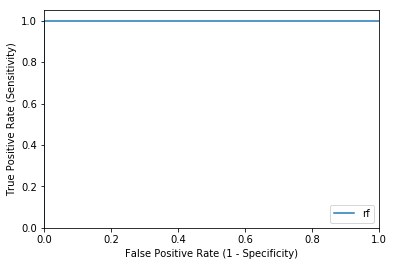

In [295]:
#generate same for random forest model
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(y_test, predicted_probs_rf[:,1])

# plot LR and RF model ROC curves
sns.mpl.pyplot.plot(fpr_rf, tpr_rf,label="rf")
sns.mpl.pyplot.xlim([0, 1])
sns.mpl.pyplot.ylim([0, 1.05])
sns.mpl.pyplot.legend(loc="lower right")
sns.mpl.pyplot.xlabel('False Positive Rate (1 - Specificity)')
sns.mpl.pyplot.ylabel('True Positive Rate (Sensitivity)')

In [296]:
# fit a classification tree with max_depth=3 on all of the training data
rf = DecisionTreeClassifier(max_depth=3, random_state=1)
rf.fit(X_train, y_train)


#compute cross-validation score accuracy across 10 folds
cross_val_scores = cross_val_score(rf,X,y,cv=10,scoring='accuracy')
print("10-fold accuracies:\n",cross_val_scores)
print("Mean cv-accuracy:",np.mean(cross_val_scores))

10-fold accuracies:
 [0.76298208 0.7487853  0.75592165 0.75144245 0.76472821 0.76480413
 0.75888248 0.7532645  0.75559942 0.7518032 ]
Mean cv-accuracy: 0.7568213437794334


In [297]:
#confusion matrix
outcome_pred = rf.predict(X_test)
cm = metrics.confusion_matrix(y_test, outcome_pred)
cm

array([[14564,  5154],
       [ 4339, 15459]], dtype=int64)

In [ ]:
# use GridSearchCV to automate the search across depths 1-10
rf_grid = RandomForestClassifier(n_estimators=50,
                                 random_state=1,
                                 n_jobs=-1) #50 trees
max_depth_range = range(1, 11)
param_grid = dict(max_depth=max_depth_range)
print(param_grid)

grid = GridSearchCV(rf_grid,
                    param_grid,
                    cv=10,
                    scoring='accuracy')
grid.fit(X, y)

# examine the results of the grid search
grid.cv_results_

grid_mean_scores = grid.cv_results_["mean_test_score"]

# plot the results
sns.mpl.pyplot.plot(max_depth_range, grid_mean_scores)
sns.mpl.pyplot.xlabel('max_depth')
sns.mpl.pyplot.ylabel('Cross-Validated Mean Test Set Accuracy');

# what was best model?
print("Best score:",grid.best_score_)
print("Best params:",grid.best_params_)
print("Best estimator:",grid.best_estimator_)

In [ ]:
# search multiple parameters simultaneously - this will take a while
rf_grid = RandomForestClassifier(n_estimators=50,
                                 random_state=1,
                                 n_jobs=-1) #50 trees
max_depth_range = range(1, 11)
leaf_range = range(1, 11)
param_grid2 = dict(max_depth=max_depth_range,
                   min_samples_leaf=leaf_range)
grid2 = GridSearchCV(rf_grid,
                     param_grid2,
                     cv=10,
                     scoring='accuracy',
                     n_jobs=-1)
grid2.fit(X, y)

print(grid2.cv_results_)

print(grid2.best_score_)
print(grid2.best_params_)